**Nama/NIM Mahasiswa 1**

Silvia Tri Maharani/24031554028

**Nama/NIM Mahasiswa 2**

Hafidzah Maulidya I. W./24031554021

**Kelas:** 2024A

**Kelompok:** 8

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
from google.colab import drive

sns.set(style="whitegrid", context="talk")

In [2]:
drive.mount('/content/drive')
folder_path = "/content/drive/MyDrive/PROJEK_DW"
print("Isi folder sumber:", os.listdir(folder_path))

all_files = glob.glob(os.path.join(folder_path, "*.xlsx"))
print("Jumlah file ditemukan:", len(all_files))

pop_raw = None
fac_raw = None
dis_raw = None

for file in all_files:
    raw_df_temp = pd.read_excel(file, header=None)
    header_row_index = 0
    for i in range(len(raw_df_temp)):
        if raw_df_temp.iloc[i].astype(str).str.contains("kabupaten/kota", case=False).any():
            header_row_index = i
            break

    df_temp = pd.read_excel(file, header=header_row_index)

    # Mengklasifikasikan file ke dataframe masing-masing
    if "jumlah penduduk" in file.lower():
        pop_raw = df_temp
    elif "jumlah rumah sakit umum" in file.lower():
        fac_raw = df_temp
    elif "kasus penyakit" in file.lower():
        dis_raw = df_temp

print("All raw dataframes loaded: pop_raw, fac_raw, dis_raw")

print("\nPreview Data Penduduk:")
print(pop_raw.head() if pop_raw is not None else "Data tidak ditemukan.")

print("\nPreview Data Rumah Sakit Umum:")
print(fac_raw.head() if fac_raw is not None else "Data tidak ditemukan.")

print("\nPreview Data Kasus Penyakit:")
print(dis_raw.head() if dis_raw is not None else "Data tidak ditemukan.")

#memasukkan semua raw data ke dictionary
raw_data = {
    "penduduk": pop_raw,
    "rumah_sakit": fac_raw,
    "penyakit": dis_raw
}

print("\nDataframe keys dalam raw_data:", list(raw_data.keys()))


Mounted at /content/drive
Isi folder sumber: ['Jumlah Penduduk Menurut Jenis Kelamin dan Kabupaten_Kota Provinsi Jawa Timur, 2023.xlsx', 'Jumlah Rumah Sakit Umum, Rumah Sakit Khusus, Puskesmas, Klinik Pratama, dan Posyandu Menurut Kabupaten.xlsx', 'Kasus Penyakit Menurut Kabupaten_Kota dan Jenis Penyakit di Provinsi Jawa Timur, 2023.xlsx']
Jumlah file ditemukan: 3
All raw dataframes loaded: pop_raw, fac_raw, dis_raw

Preview Data Penduduk:
  Kabupaten/Kota Se Jawa Timur  \
0                          NaN   
1                          NaN   
2                          NaN   
3            Kabupaten Pacitan   
4           Kabupaten Ponorogo   

                                          Unnamed: 1 Unnamed: 2  \
0  Jumlah Penduduk Menurut Jenis Kelamin dan Kabu...        NaN   
1                                          Laki-laki  Perempuan   
2                                               2023       2023   
3                                             298826     297823   
4               

DATA CLEANING

In [3]:
# Cleaning Penduduk
pop = pop_raw.rename(columns={
    pop_raw.columns[0]: "kabupaten_raw",
    pop_raw.columns[1]: "penduduk_lk",
    pop_raw.columns[2]: "penduduk_pr",
    pop_raw.columns[3]: "penduduk_total"
})

pop = pop[pop["kabupaten_raw"].notna() & (pop["kabupaten_raw"] != "Jawa Timur")].copy()

# Convert numeric columns
pop["penduduk_lk"] = pd.to_numeric(pop["penduduk_lk"], errors='coerce')
pop["penduduk_pr"] = pd.to_numeric(pop["penduduk_pr"], errors='coerce')
pop["penduduk_total"] = pd.to_numeric(pop["penduduk_total"], errors='coerce')

def simplify(name):
    name = str(name).strip()
    if name.startswith("Kabupaten "):
        return name.replace("Kabupaten ", "")
    if name.startswith("Kota "):
        return name.replace("Kota ", "")
    return name
pop["kab_sederhana"] = pop["kabupaten_raw"].map(simplify)


In [4]:
# Cleaning Faskes
fac_raw["kab_sederhana"] = fac_raw["Kabupaten/Kota"].map(simplify)
fac = fac_raw[fac_raw["kab_sederhana"] != "Jawa Timur"].copy()

faskes_cols = [
    "Jumlah Rumah Sakit Umum",
    "Jumlah Rumah Sakit Khusus",
    "Jumlah Puskesmas Rawat Inap",
    "Jumlah Puskesmas Non Rawat Inap",
    "Jumlah Klinik Pratama",
    "Jumlah Posyandu"
]

for col in faskes_cols:
    fac[col] = fac[col].fillna(0)

# Hapus duplikasi kabupaten/kota pada data faskes
fac = fac.drop_duplicates(subset=["kab_sederhana"], keep="first")


In [5]:
# Cleaning Penyakit
dis_raw["kab_sederhana"] = dis_raw["Kabupaten/Kota"].map(simplify)
dis = dis_raw[dis_raw["kab_sederhana"] != "Jawa Timur"].copy()

penyakit_cols = [
    "Jumlah Kasus Penyakit - Angka Penemuan TBC",
    "Jumlah Kasus Penyakit - Angka Keberhasilan Pengobatan TBC",
    "Jumlah Kasus Penyakit - HIV/AIDS Kasus Baru",
    "Jumlah Kasus Penyakit - Penemuan Kasus Baru Kusta per 100.000 Penduduk",
    "Jumlah Kasus Penyakit - Angka Kesakitan Malaria per 1.000 Penduduk",
    "Jumlah Kasus Penyakit - Angka Kesakitan DBD per 100.000 Penduduk"
]

for col in penyakit_cols:
    dis[col] = dis[col].fillna(0)

# Hapus duplikasi kabupaten/kota
dis = dis.drop_duplicates(subset=["kab_sederhana"], keep="first")

DATA EKSPLORASI

In [6]:
print(pop.info())
print(fac.info())
print(dis.info())

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 3 to 40
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   kabupaten_raw   38 non-null     object
 1   penduduk_lk     38 non-null     int64 
 2   penduduk_pr     38 non-null     int64 
 3   penduduk_total  38 non-null     int64 
 4   kab_sederhana   38 non-null     object
dtypes: int64(3), object(2)
memory usage: 1.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, 0 to 37
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Kabupaten/Kota                   31 non-null     object 
 1   Jumlah Rumah Sakit Umum          31 non-null     int64  
 2   Jumlah Rumah Sakit Khusus        31 non-null     float64
 3   Jumlah Puskesmas Rawat Inap      31 non-null     float64
 4   Jumlah Puskesmas Non Rawat Inap  31 non-null     float64
 5   Juml

In [7]:
# MERGE + VARIABEL TURUNAN
df = pop.merge(fac, on="kab_sederhana", how="inner")
df = df.merge(dis, on="kab_sederhana", how="inner")
df["kabupaten_kota"] = df["kab_sederhana"]

print("Jumlah baris pop:", len(pop))
print("Jumlah baris fac:", len(fac))
print("Jumlah baris dis:", len(dis))
print("Jumlah baris hasil merge:", len(df))


Jumlah baris pop: 38
Jumlah baris fac: 31
Jumlah baris dis: 31
Jumlah baris hasil merge: 38


In [8]:
# Rename penyakit
df = df.rename(columns={
    "Jumlah Kasus Penyakit - Angka Penemuan TBC":"tbc_penemuan",
    "Jumlah Kasus Penyakit - HIV/AIDS Kasus Baru":"hiv_baru",
    "Jumlah Kasus Penyakit - Angka Kesakitan DBD per 100.000 Penduduk":"dbd_per_100k",
    "Jumlah Kasus Penyakit - Angka Kesakitan Malaria per 1.000 Penduduk": "malaria_per_1k",
    "Jumlah Kasus Penyakit - Penemuan Kasus Baru Kusta per 100.000 Penduduk": "kusta_per_100k"
})

In [9]:
# Variabel turunan
df["faskes_total"] = (
    df["Jumlah Rumah Sakit Umum"] +
    df["Jumlah Rumah Sakit Khusus"] +
    df["Jumlah Puskesmas Rawat Inap"] +
    df["Jumlah Puskesmas Non Rawat Inap"] +
    df["Jumlah Klinik Pratama"] +
    df["Jumlah Posyandu"]
)

df["faskes_per_100k"] = df["faskes_total"] / df["penduduk_total"] * 100000
df["hiv_per_100k"] = df["hiv_baru"] / df["penduduk_total"] * 100000
df["malaria_per_100k"] = df["malaria_per_1k"] * 100
df["index_vektor"] = df["dbd_per_100k"] + df["malaria_per_100k"]
df["index_kronis"] = df["tbc_penemuan"] + df["hiv_per_100k"] + df["kusta_per_100k"]
df["index_total_penyakit"] = df["index_vektor"] + df["index_kronis"]

df.to_csv("data_clean_jatim_2023_final.csv", index=False)

In [10]:
# FUNGSI KESIMPULAN DI BAWAH GRAFIK
def add_summary(text):
    plt.gcf().text(
        0.02, -0.18, text,
        fontsize=12,
        ha='left',
        va='top',
        bbox=dict(facecolor="#f0f0f0", edgecolor="gray", boxstyle="round,pad=0.5")
    )

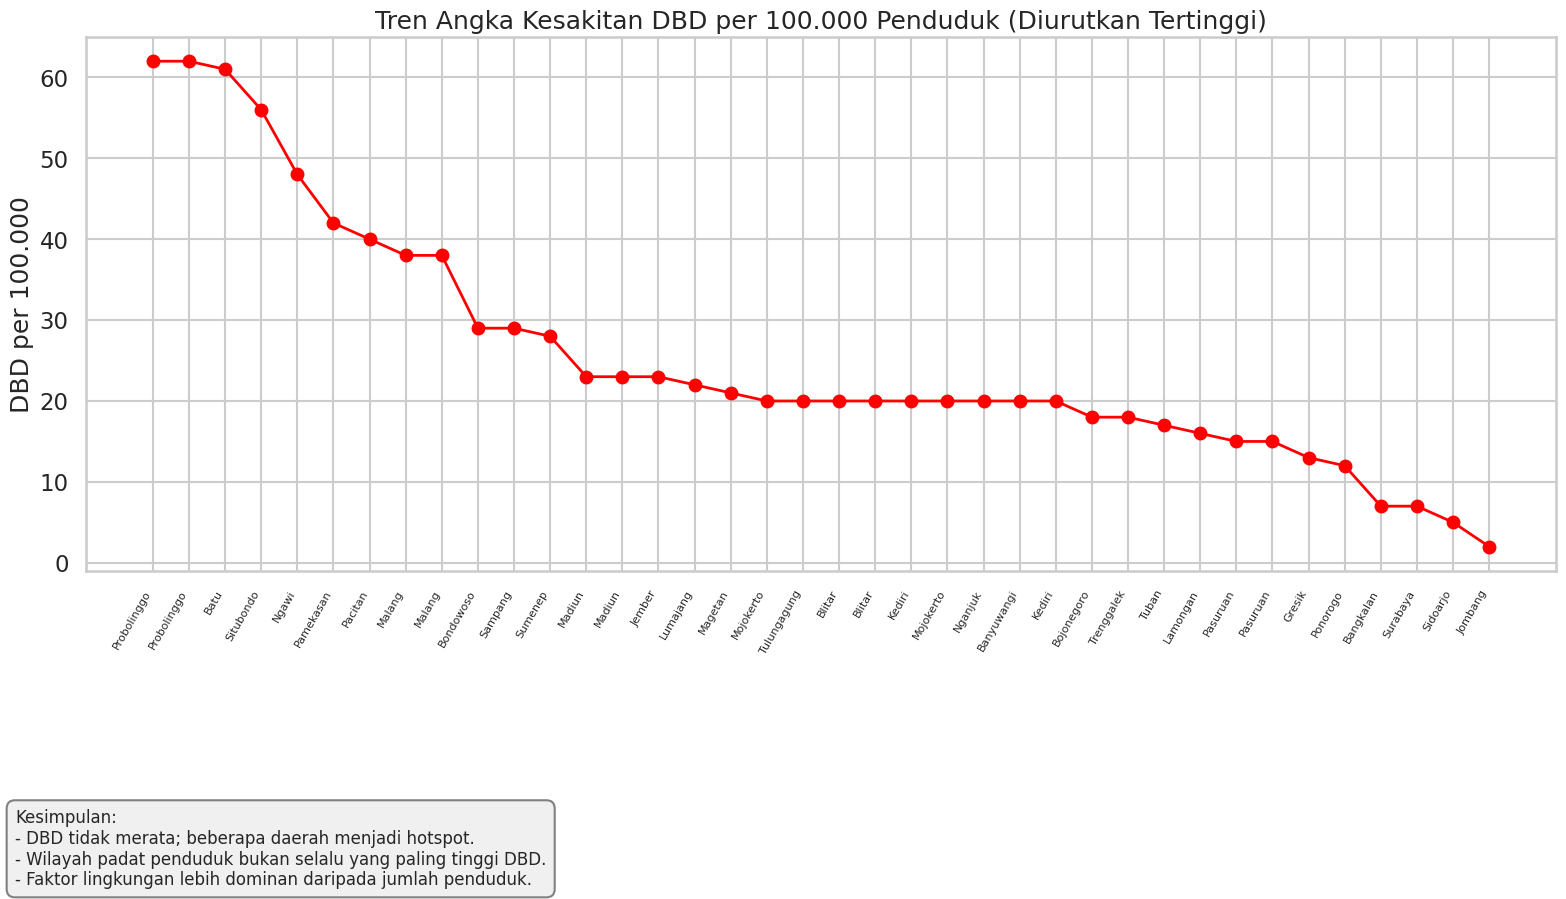

In [11]:
# GRAFIK 1 – LINE CHART DBD + SUMMARY
df_line = df.sort_values("dbd_per_100k", ascending=False).reset_index(drop=True)

plt.figure(figsize=(16,7))
plt.plot(df_line.index+1, df_line["dbd_per_100k"], marker="o", linewidth=2, color="red")
plt.xticks(df_line.index+1, df_line["kabupaten_kota"], rotation=60, fontsize=8, ha="right")
plt.title("Tren Angka Kesakitan DBD per 100.000 Penduduk (Diurutkan Tertinggi)")
plt.ylabel("DBD per 100.000")

add_summary(
    "Kesimpulan:\n"
    "- DBD tidak merata; beberapa daerah menjadi hotspot.\n"
    "- Wilayah padat penduduk bukan selalu yang paling tinggi DBD.\n"
    "- Faktor lingkungan lebih dominan daripada jumlah penduduk."
)

plt.tight_layout()
plt.show()

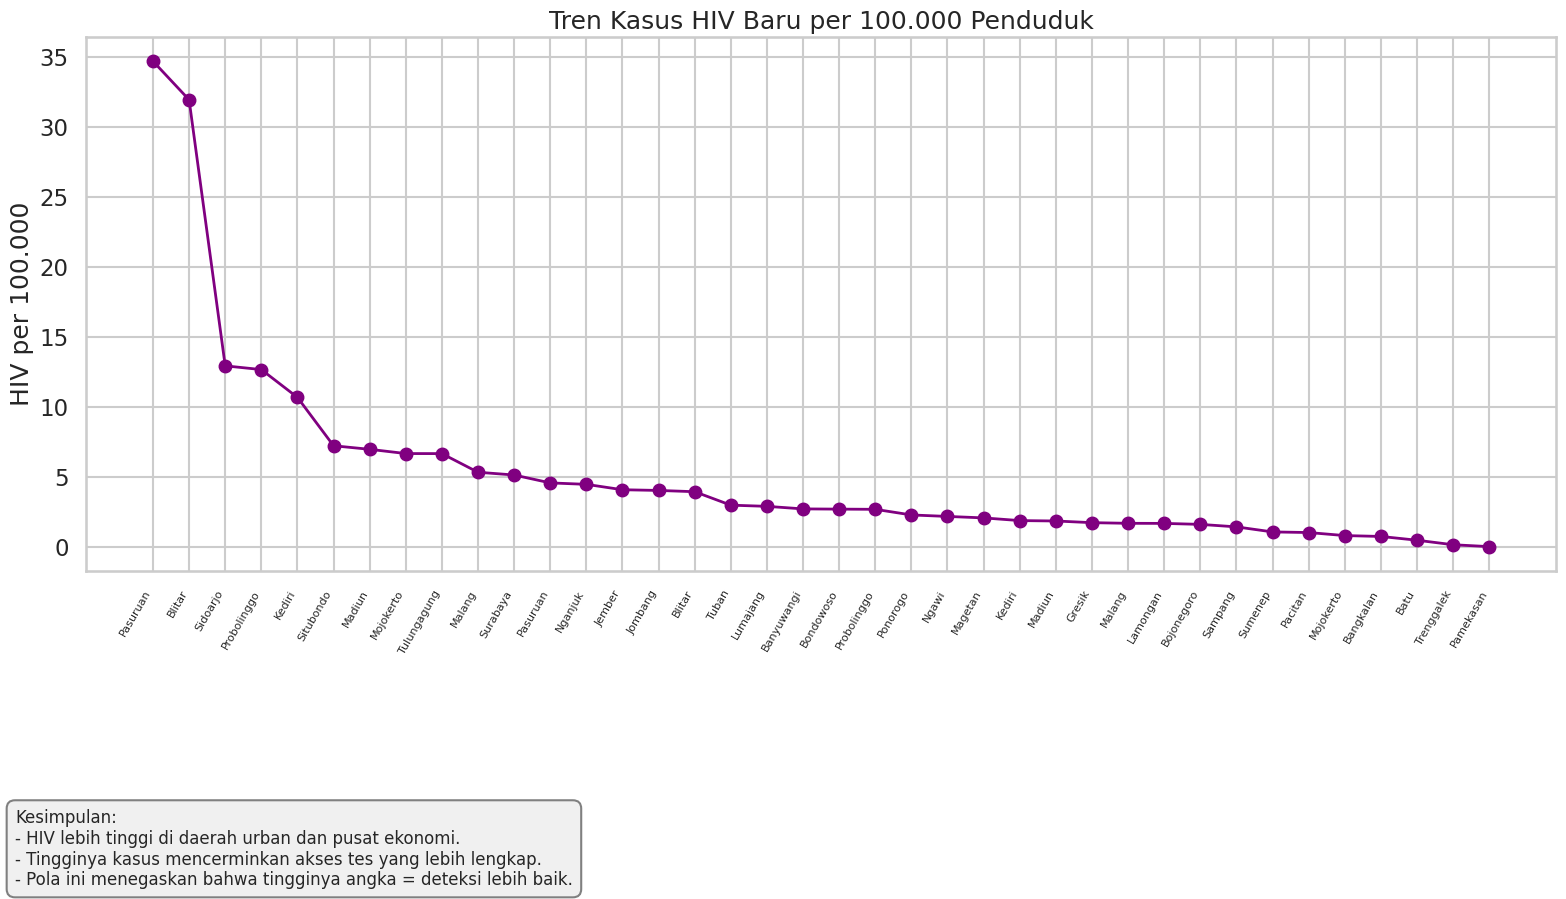

In [12]:
# GRAFIK 2 – LINE CHART HIV + SUMMARY
df_hiv = df.sort_values("hiv_per_100k", ascending=False).reset_index(drop=True)

plt.figure(figsize=(16,7))
plt.plot(df_hiv.index+1, df_hiv["hiv_per_100k"], marker="o", linewidth=2, color="purple")
plt.xticks(df_hiv.index+1, df_hiv["kabupaten_kota"], rotation=60, fontsize=8, ha="right")
plt.title("Tren Kasus HIV Baru per 100.000 Penduduk")
plt.ylabel("HIV per 100.000")

add_summary(
    "Kesimpulan:\n"
    "- HIV lebih tinggi di daerah urban dan pusat ekonomi.\n"
    "- Tingginya kasus mencerminkan akses tes yang lebih lengkap.\n"
    "- Pola ini menegaskan bahwa tingginya angka = deteksi lebih baik."
)

plt.tight_layout()
plt.show()

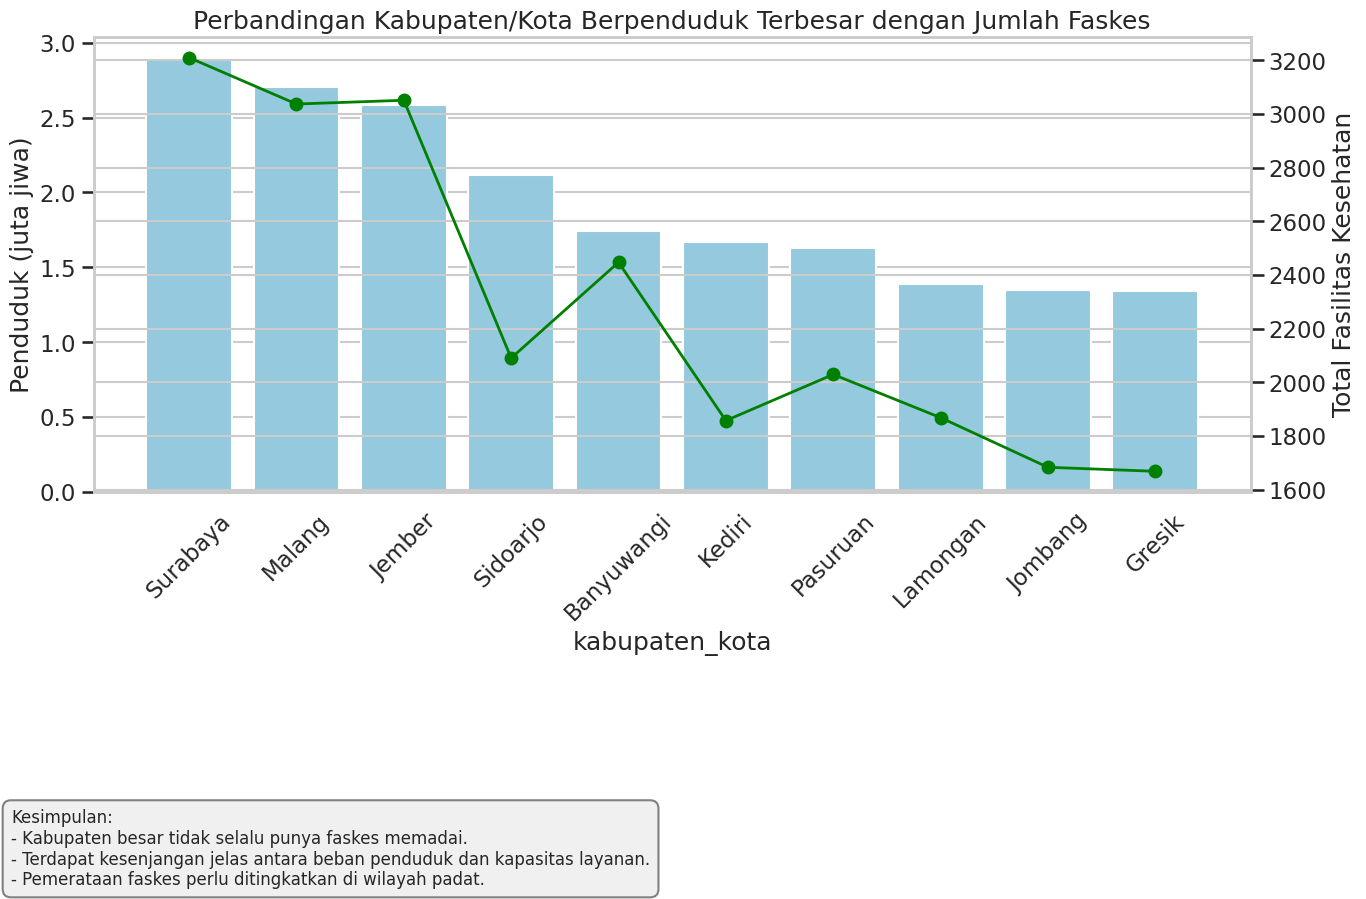

In [13]:
# GRAFIK 3 – PERBANDINGAN PENDUDUK VS FASKES + SUMMARY
df["penduduk_juta"] = df["penduduk_total"] / 1_000_000
df_pb = df.sort_values("penduduk_total", ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(14,7))
sns.barplot(x="kabupaten_kota", y="penduduk_juta", data=df_pb, color="skyblue", ax=ax1)
ax1.set_ylabel("Penduduk (juta jiwa)")
ax1.tick_params(axis="x", rotation=45)

ax2 = ax1.twinx()
ax2.plot(df_pb["kabupaten_kota"], df_pb["faskes_total"], marker="o", linewidth=2, color="green")
ax2.set_ylabel("Total Fasilitas Kesehatan")
plt.title("Perbandingan Kabupaten/Kota Berpenduduk Terbesar dengan Jumlah Faskes")

add_summary(
    "Kesimpulan:\n"
    "- Kabupaten besar tidak selalu punya faskes memadai.\n"
    "- Terdapat kesenjangan jelas antara beban penduduk dan kapasitas layanan.\n"
    "- Pemerataan faskes perlu ditingkatkan di wilayah padat."
)

plt.tight_layout()
plt.show()

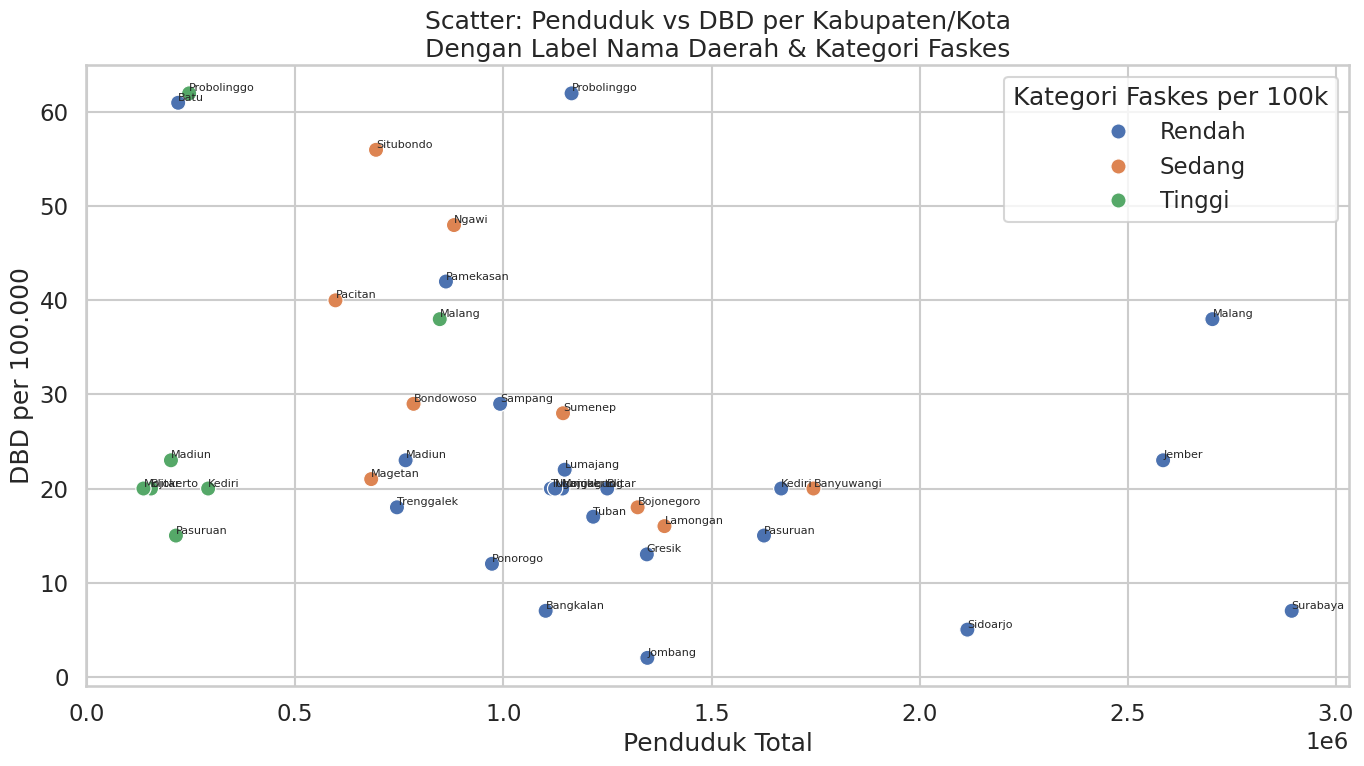

In [14]:
# GRAFIK 4 – SCATTER KEPADATAN VS DBD + faskes

# kategori faskes per 100k: Rendah / Sedang / Tinggi
current_max_faskes = df["faskes_per_100k"].max()
calculated_bins = []
calculated_labels = []

if current_max_faskes <= 130:
    calculated_bins = [0, current_max_faskes]
    calculated_labels = ["Rendah"]
elif current_max_faskes <= 250:
    calculated_bins = [0, 130, current_max_faskes]
    calculated_labels = ["Rendah", "Sedang"]
else: # current_max_faskes > 250
    calculated_bins = [0, 130, 250, current_max_faskes]
    calculated_labels = ["Rendah", "Sedang", "Tinggi"]

df["kategori_faskes"] = pd.cut(
    df["faskes_per_100k"],
    bins=calculated_bins,
    labels=calculated_labels,
    include_lowest=True
)
plt.figure(figsize=(14,8))

sns.scatterplot(
    x="penduduk_total",
    y="dbd_per_100k",
    hue="kategori_faskes",
    data=df,
    s=120
)

# Menambahkan label untuk setiap titik
for i in range(len(df)):
    plt.text(
        df["penduduk_total"].iloc[i],
        df["dbd_per_100k"].iloc[i],
        df["kabupaten_kota"].iloc[i],
        fontsize=8,
        ha='left',
        va='bottom'
    )

plt.title("Scatter: Penduduk vs DBD per Kabupaten/Kota\nDengan Label Nama Daerah & Kategori Faskes")
plt.xlabel("Penduduk Total")
plt.ylabel("DBD per 100.000")
plt.legend(title="Kategori Faskes per 100k")

plt.tight_layout()
plt.show()

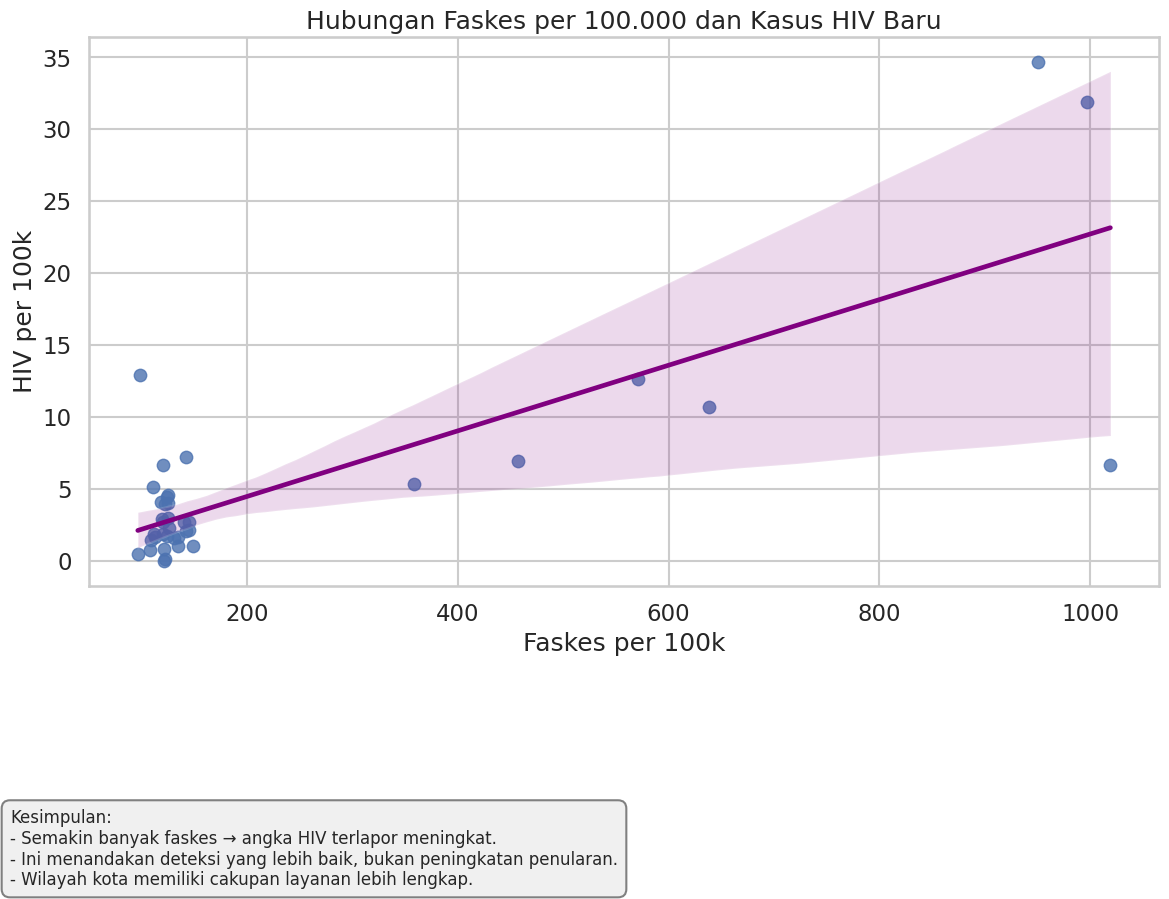

In [15]:
# GRAFIK 5 – SCATTER FASKES vs HIV + SUMMARY

df_scatter = df.dropna(subset=["faskes_per_100k", "hiv_per_100k"])

plt.figure(figsize=(12,7))
sns.regplot(
    x="faskes_per_100k",
    y="hiv_per_100k",
    data=df_scatter,
    scatter_kws={"s":80},
    line_kws={"color":"purple"}
)

plt.title("Hubungan Faskes per 100.000 dan Kasus HIV Baru")
plt.xlabel("Faskes per 100k")
plt.ylabel("HIV per 100k")

add_summary(
    "Kesimpulan:\n"
    "- Semakin banyak faskes → angka HIV terlapor meningkat.\n"
    "- Ini menandakan deteksi yang lebih baik, bukan peningkatan penularan.\n"
    "- Wilayah kota memiliki cakupan layanan lebih lengkap."
)

plt.tight_layout()
plt.show()


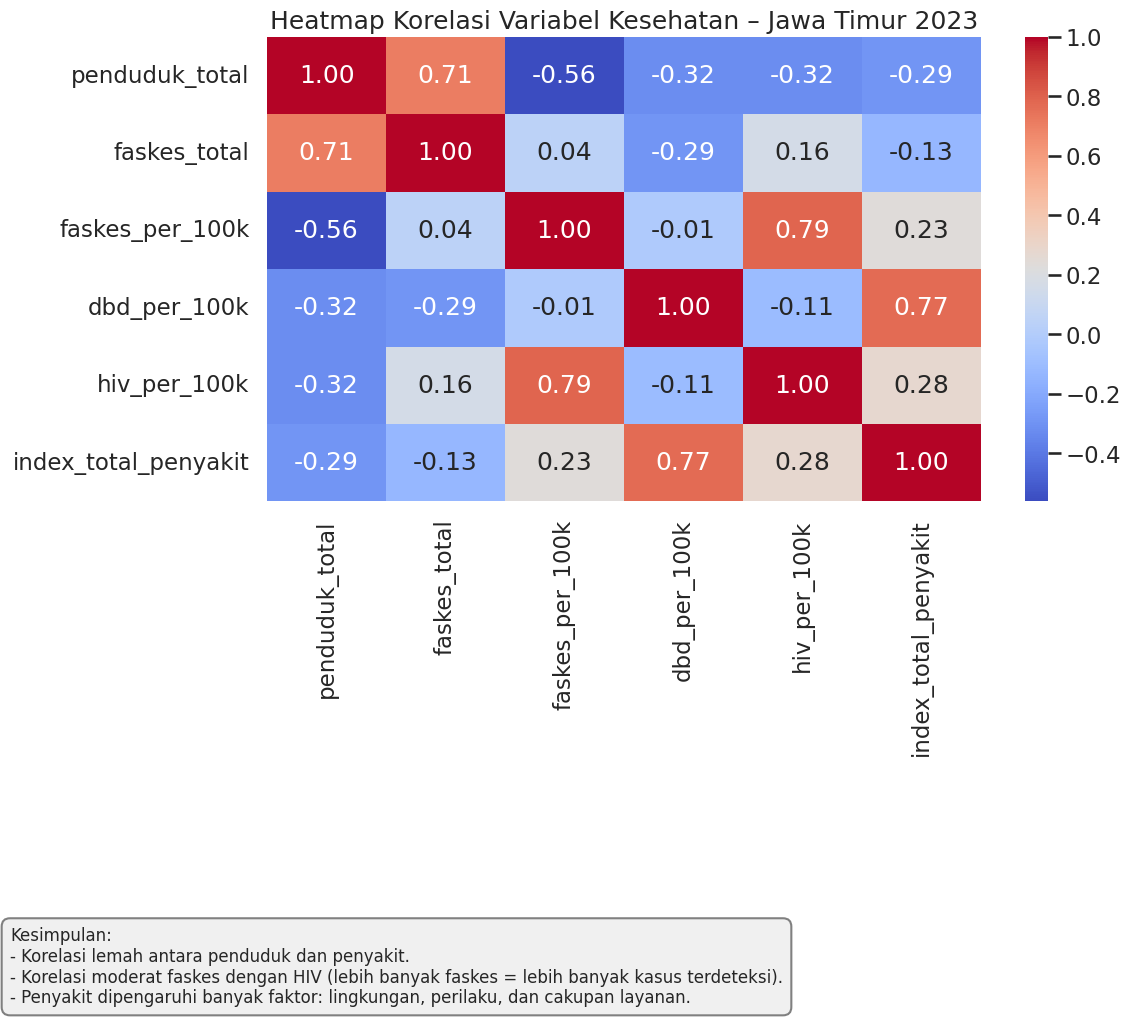

In [16]:
# GRAFIK 6 – HEATMAP KORELASI + SUMMARY
corr_cols = [
    "penduduk_total", "faskes_total", "faskes_per_100k",
    "dbd_per_100k", "hiv_per_100k", "index_total_penyakit"
]

plt.figure(figsize=(12,8))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Korelasi Variabel Kesehatan – Jawa Timur 2023")

add_summary(
    "Kesimpulan:\n"
    "- Korelasi lemah antara penduduk dan penyakit.\n"
    "- Korelasi moderat faskes dengan HIV (lebih banyak faskes = lebih banyak kasus terdeteksi).\n"
    "- Penyakit dipengaruhi banyak faktor: lingkungan, perilaku, dan cakupan layanan."
)

plt.tight_layout()
plt.show()
